In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [7]:
chunksize = 100

list_of_dataframes = []

for df in pd.read_csv('ImputedScaledData.csv', chunksize=chunksize, index_col=0):
    list_of_dataframes.append(df)

result = pd.concat(list_of_dataframes)
df = result

ax_columns = [col for col in df.columns if col.startswith('AX')]
# len(ax_columns)
X = df[ax_columns]
y = df["Status"]
X = X.to_numpy()
y = y.to_numpy()

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y)
    
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.78322705, -0.7567372 , -0.0203195 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.78322705, -0.7567372 , -0.0203195 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.78322705, -0.7567372 , -0.0203195 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.78322705, -0.7567372 , -0.0203195 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.78322705, -0.7567372 , -0.0203195 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.91054037,  2.19113134, -0.0203195 , ...,  0.        ,
         0.        ,  0.        ]])

Kinship matrix shape: (2423, 2423)


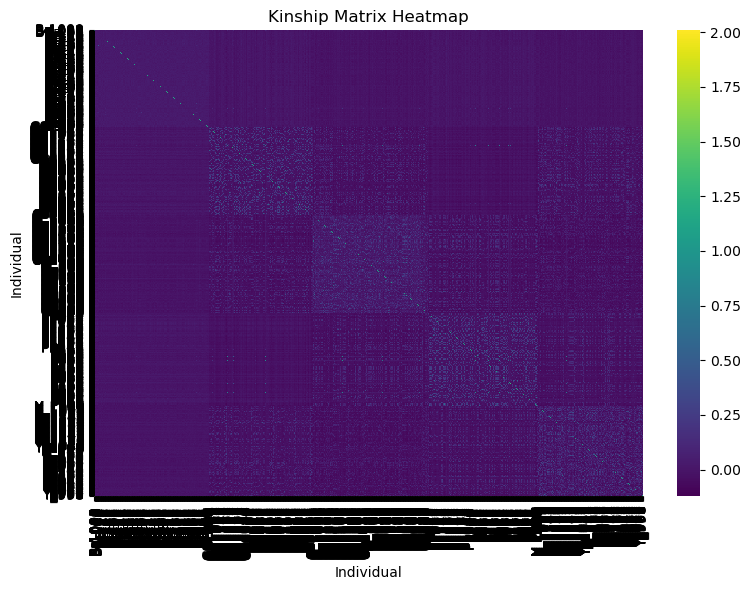

: 

In [53]:
X_new = df[ax_columns]
X_new
X_new = X_new.to_numpy()

def compute_kinship_matrix(X):
    # Step 1: Standardize genotype matrix (center by allele frequency)
    p = np.mean(X, axis=0) / 2.0        # Allele frequency for each SNP
    Z = X - 2 * p                       # Center genotypes by 2p
    denom = 2 * np.sum(p * (1 - p))     # Normalization term

    # Step 2: Genomic Relationship Matrix (VanRaden I method)
    K = np.dot(Z, Z.T) / denom          # K is (n_samples x n_samples)
    return K
    
K = compute_kinship_matrix(X_new)
print("Kinship matrix shape:", K.shape)

def plot_kinship_heatmap(K, sample_labels=None, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.heatmap(K, cmap='viridis', xticklabels=sample_labels, yticklabels=sample_labels)
    plt.title("Kinship Matrix Heatmap")
    plt.xlabel("Individual")
    plt.ylabel("Individual")
    plt.tight_layout()
    plt.show()
plot_kinship_heatmap(K, sample_labels=df.index.tolist())

In [38]:
class GEBVCNN(torch.nn.Module):

    def __init__(self, input_length, kernel_size=50, pool_size=10, dropout_rate=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.pool = nn.MaxPool1d(pool_size)
        self.dropout = nn.Dropout(dropout_rate)

        # Compute output size after pooling
        conv_out_len = (input_length - kernel_size + 1) // pool_size
        flattened_size = 64 * conv_out_len

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, input_length)

        x = F.relu(self.bn1(self.conv1(x)))  # (batch, 32, L)
        x = F.relu(self.bn2(self.conv2(x)))  # (batch, 64, L)
        x = self.pool(x)                     # (batch, 64, L_pooled)

        x = x.view(x.size(0), -1)            # Flatten: (batch, 64 * L_pooled)
        x = F.relu(self.fc1(x))              # FC1: (batch, 64)
        x = self.dropout(x)                  # Dropout
        x = self.fc2(x)                      # Final output: (batch, 1)
        return x



Plan: 

start with LR - output sigmoid probability  
then: test SVM, RF using sklearn    
then: build PNN (probabilistic neural net)  
then: try full MLP/CNN using sigmoid activation  

eventual HP tuning necessary  
can evaluate model effectiveness using AUC/ROC